In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
import numpy as np
import skimage

import starfish as sf
from starfish.types import Coordinates, Axes, Clip, Features

In [5]:
experiment = sf.data.MERFISH()

In [11]:
image = experiment['fov_000'].get_image('primary')
nuclei = experiment['fov_000'].get_image('nuclei')

ghp = sf.image.Filter.GaussianHighPass(sigma=3)
high_passed = ghp.run(image, verbose=True, in_place=False)

dpsf = sf.image.Filter.DeconvolvePSF(num_iter=15, sigma=2, clip_method=Clip.SCALE_BY_CHUNK)
deconvolved = dpsf.run(high_passed, verbose=True, in_place=False)

glp = sf.image.Filter.GaussianLowPass(sigma=1)
low_passed = glp.run(deconvolved, in_place=False, verbose=True)

scale_factors = {
    (t[Axes.ROUND], t[Axes.CH]): t['scale_factor']
    for t in experiment.extras['scale_factors']
}

# this is a scaling method. It would be great to use image.apply here. It's possible, but we need to expose H & C to
# at least we can do it with get_slice and set_slice right now.
from copy import deepcopy
filtered_imgs = deepcopy(low_passed)

for selector in image._iter_axes():
    data = filtered_imgs.get_slice(selector)[0]
    scaled = data / scale_factors[selector[Axes.ROUND.value], selector[Axes.CH.value]]
    filtered_imgs.set_slice(selector, scaled, [Axes.ZPLANE])
    
psd = sf.spots.DetectPixels.PixelSpotDecoder(
    codebook=experiment.codebook,
    metric='euclidean',
    norm_order=2,
    distance_threshold=0.5176,
    magnitude_threshold=1.77e-5,
    min_area=2,
    max_area=np.inf,
)

initial_spot_intensities, prop_results = psd.run(filtered_imgs)

spot_intensities = initial_spot_intensities.loc[initial_spot_intensities[Features.PASSES_THRESHOLDS]]

Note here I'm saving a nucleus. I could _also_ try to save a point cloud by max projecting the data. Ilastik is flexible. 

In [24]:
skimage.io.imsave("dapi.tiff", np.squeeze(nuclei.xarray))

/Users/ajc/.spatial/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: dapi.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


Here, we run the ilastik classifier. It generates a data file that's of size (y, x, num_labels) and each slice corresponds to the probability that a pixel corresponds to a given label. We use nuclei, background, for a (y, x, 2) file. It's stored in hdf5, and loadable as a numpy array as follows:

In [150]:
import h5py

# load the nuclei segmentation mask
conn = h5py.File('dapi_Probabilities.h5')
probabilities = conn['exported_data'][:, :, 0]
conn.close()

The probabilities haven't been thresholded or segmented yet, so we do that.

In [247]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
import scipy.ndimage as ndi
from skimage.measure import label

def watershed_probabilities(probabilities: np.ndarray):
    
    # create mask
    selem = skimage.morphology.disk(3)
    smoothed_mask = skimage.morphology.opening(probabilities, selem=selem)
    thresholded_mask = smoothed_mask > 0.1
    
    # distance transform on basins
    dist = ndi.distance_transform_edt(probabilities)

    # get local maxima, convert those to markers
    local_max = peak_local_max(dist, labels=probabilities, indices=False, min_distance=100, exclude_border=0)
    markers = label(local_max)

    
    objects = watershed(-dist, markers=markers, mask=thresholded_mask)
    
    return markers, dist, thresholded_mask, objects

markers, dist, mask, objects = watershed_probabilities(probabilities)

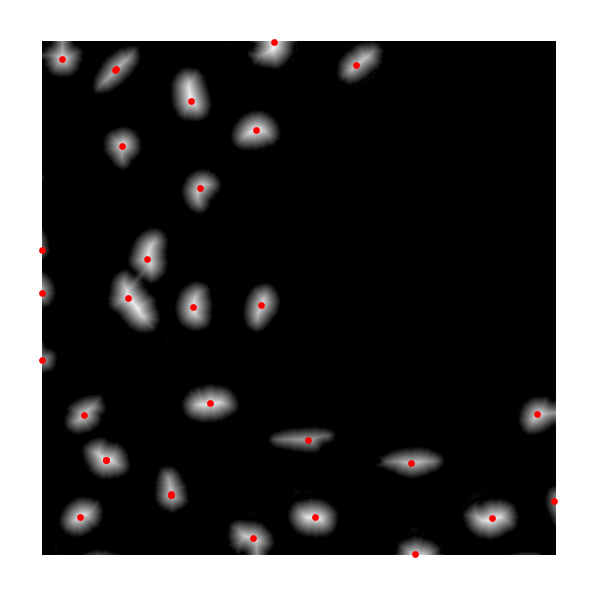

In [152]:
# confirm markers make sense. 
f, ax = plt.subplots(dpi=150, figsize=(5, 5))
y, x = np.where(markers)
plt.imshow(dist, cmap=plt.cm.gray)
plt.scatter(x, y, c='r', s=5)
ax.axes.set_axis_off()

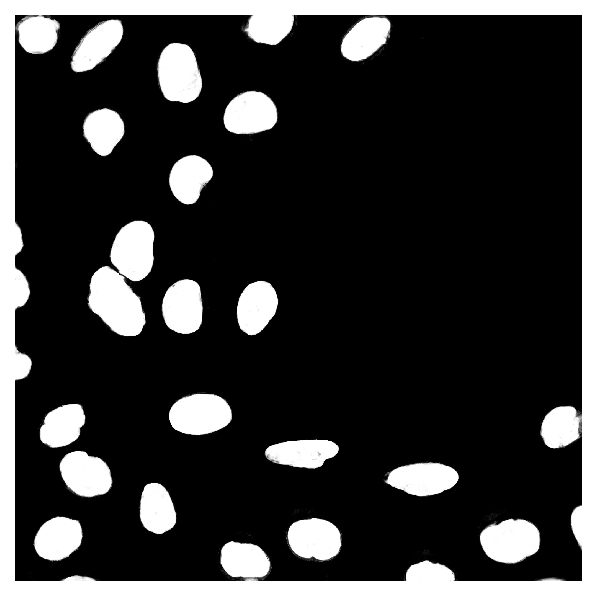

In [155]:
f, ax = plt.subplots(figsize=(5, 5), dpi=150)
plt.imshow(mask, plt.cm.gray)
ax.axes.set_axis_off()

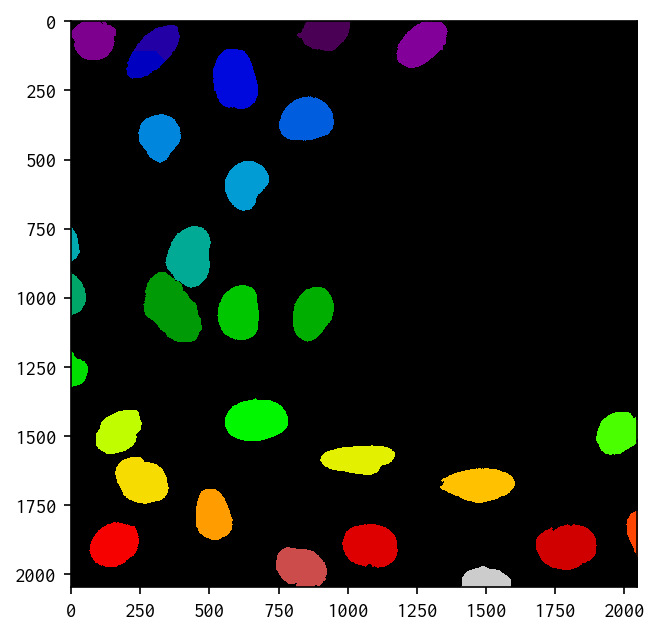

In [156]:
f, ax = plt.subplots(dpi=150, figsize=(5, 5))
plt.imshow(objects, cmap=plt.cm.nipy_spectral)

If we wanted to convert these into starfish objects, here's how we'd do it:

In [34]:
nuclei_probabilities = sf.ImageStack.from_numpy(mask[None, None, None, :], coordinates=image.xarray.coords)

100%|██████████| 1/1 [00:00<00:00, 89.34it/s]


In [48]:
objects = watershed(-dist, markers=markers, mask=mask)

coordinates = {
    Coordinates.Y: image.xarray.coords['yc'],    
    Coordinates.X: image.xarray.coords['xc'],
}

smc = sf.core.segmentation_mask.SegmentationMaskCollection.from_label_image(objects, physical_ticks=coordinates)

# Assign points to nearest nucleus

For the mask collection, i think there could be some metadata we want to be able to easily extract from them and translate to the set of global coordinates. At th emoment I just see (y, x) on them... probably want these masks to be plottable in global coordinates, too, and for the regionprops information to be translateable in both domains? 

In [75]:
smc._masks[:2]

[<xarray.DataArray '01' (y: 118, x: 208)>
 array([[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])
 Coordinates:
   * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 109 110 111 112 113 114 115 116 117
   * x        (x) int64 814 815 816 817 818 819 ... 1016 1017 1018 1019 1020 1021
     yc       (y) float64 -1.5e+03 -1.5e+03 -1.5e+03 ... -1.489e+03 -1.489e+03
     xc       (x) float64 -2.92e+03 -2.92e+03 -2.92e+03 ... -2.9e+03 -2.9e+03,
 <xarray.DataArray '02' (y: 149, x: 170)>
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False

For now, it's easier to work from the larger segmentation mask, since centroids are easier to find. The following function uses the mask to assign points to the nearest nucleus. 

In [239]:
from skimage.measure import label, regionprops
from sklearn.neighbors import NearestNeighbors

def assign_nearest_cell(intensity_table: sf.IntensityTable, label_image: np.ndarray, max_distance: int = np.inf):
    
    object_properties = regionprops(label_image)
    centroids = np.array([list(p.centroid) for p in object_properties])
    
    point_coordinates = np.stack([
        intensity_table['y'].values,
        intensity_table['x'].values,
    ], axis=1)
    
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(centroids)
    dist, cell_ids = nn.kneighbors(point_coordinates)
    
    # convert to str, mask cells that are too far
    cell_ids = cell_ids.astype('<U8')
    cell_ids[dist >= max_distance] = 'nan'

    # note that this will label each centroid with a unique, sequential integer.     
    intensity_table[Features.CELL_ID] = (Features.AXIS, np.ravel(cell_ids))
    
    return intensity_table

assigned_spots = assign_nearest_cell(spot_intensities, objects)

Validate the assignment looks OK. 

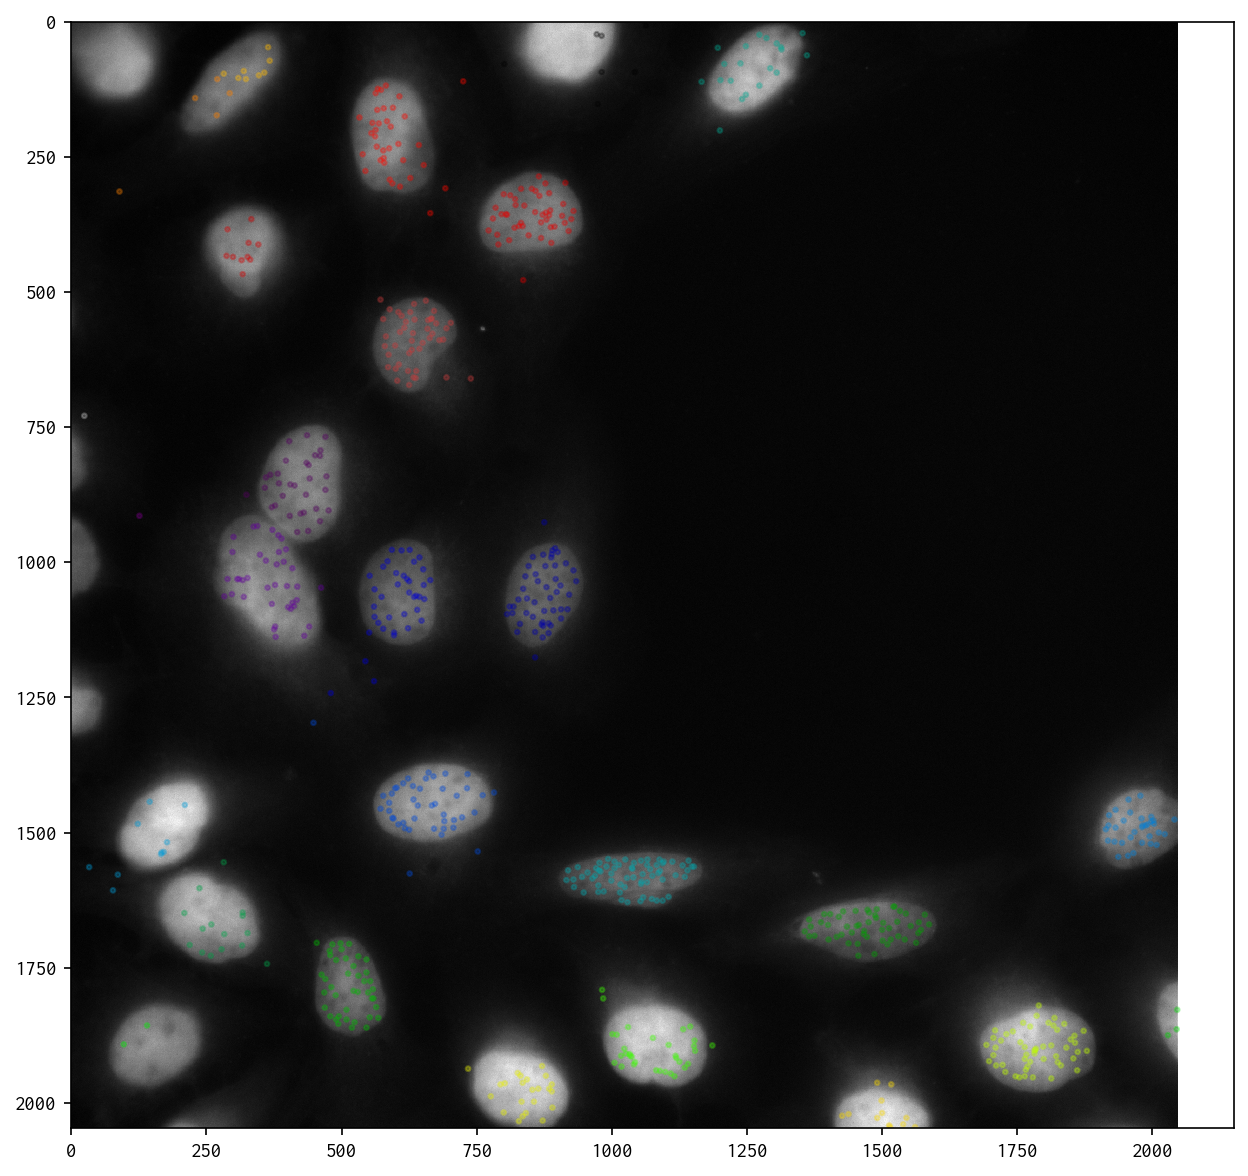

In [120]:
colors_to_cells = {cell: i for i, cell in enumerate(np.unique(cxg.cell_id))}
colors = np.array([colors_to_cells[i] for i in assigned_spots.cell_id.values])

f, ax = plt.subplots(figsize=(10, 10), dpi=150)
plt.imshow(np.squeeze(nuclei.xarray), cmap=plt.cm.gray)
plt.scatter(assigned_spots.x, assigned_spots.y, c=colors, alpha=0.3, cmap=plt.cm.nipy_spectral, s=5)

Create a cellxgene matrix. 

In [103]:
cxg = assigned_spots.to_expression_matrix()

From here, you'd go do some biology. 

## Re-use the trained model

... on a different field of view.

In [168]:
from subprocess import Popen, call, PIPE
import os

In [163]:
ILASTIK_EXECUTABLE =  "/Applications/ilastik-1.3.2post1-OSX.app/Contents/ilastik-release/run_ilastik.sh" 
ILASTIK_MODEL = os.path.expanduser("~/google_drive/czi/spatial-approaches/in-situ-transcriptomics/MERFISH/2016_moffit_pnas_merfish/pixel_classification.ilp")

In [175]:

def process_merfish(experiment, fov="fov_000"):
    print('downloading data...')
    image = experiment[fov].get_image('primary')
    nuclei = experiment[fov].get_image('nuclei')

    print('filtering...')
    ghp = sf.image.Filter.GaussianHighPass(sigma=3)
    high_passed = ghp.run(image, verbose=True, in_place=False)

    dpsf = sf.image.Filter.DeconvolvePSF(num_iter=15, sigma=2, clip_method=Clip.SCALE_BY_CHUNK)
    deconvolved = dpsf.run(high_passed, verbose=True, in_place=False)

    glp = sf.image.Filter.GaussianLowPass(sigma=1)
    low_passed = glp.run(deconvolved, in_place=False, verbose=True)

    print('rescaling...')
    scale_factors = {
        (t[Axes.ROUND], t[Axes.CH]): t['scale_factor']
        for t in experiment.extras['scale_factors']
    }

    # this is a scaling method. It would be great to use image.apply here. It's possible, but we need to expose H & C to
    # at least we can do it with get_slice and set_slice right now.
    from copy import deepcopy
    filtered_imgs = deepcopy(low_passed)

    for selector in image._iter_axes():
        data = filtered_imgs.get_slice(selector)[0]
        scaled = data / scale_factors[selector[Axes.ROUND.value], selector[Axes.CH.value]]
        filtered_imgs.set_slice(selector, scaled, [Axes.ZPLANE])

    print('finding spots...')
    psd = sf.spots.DetectPixels.PixelSpotDecoder(
        codebook=experiment.codebook,
        metric='euclidean',
        norm_order=2,
        distance_threshold=0.5176,
        magnitude_threshold=1.77e-5,
        min_area=2,
        max_area=np.inf,
    )

    initial_spot_intensities, prop_results = psd.run(filtered_imgs)

    spot_intensities = initial_spot_intensities.loc[initial_spot_intensities[Features.PASSES_THRESHOLDS]]

    print('finding nuclei...')
    # run pre-trained nuclei pixel classifier

    dapi_image = f"dapi_{fov}.tiff"
    skimage.io.imsave(dapi_image, np.squeeze(nuclei.xarray))
    cmdstr = f"{ILASTIK_EXECUTABLE} --headless --project={ILASTIK_MODEL} {dapi_image}"
    p = Popen(cmdstr, stderr=PIPE, stdout=PIPE, shell=True)
    out, err = p.communicate()

    # open the probabilties
    conn = h5py.File(f"{os.path.splitext(dapi_image)[0]}_Probabilities.h5", "r")
    probabilities = conn['exported_data'][:, :, 0]
    conn.close()

    print('segmenting...')
    markers, dist, mask, objects = watershed_probabilities(probabilities)

    print('assigning spots...')
    assigned_spots = assign_nearest_cell(spot_intensities, objects)

    print('constructing expression matrix...')
    cxg = assigned_spots.to_expression_matrix()

    return assigned_spots, cxg, markers, dist, mask, objects


assigned_spots, cxg, markers, dist, mask, objects = process_merfish(experiment, fov="fov_006")

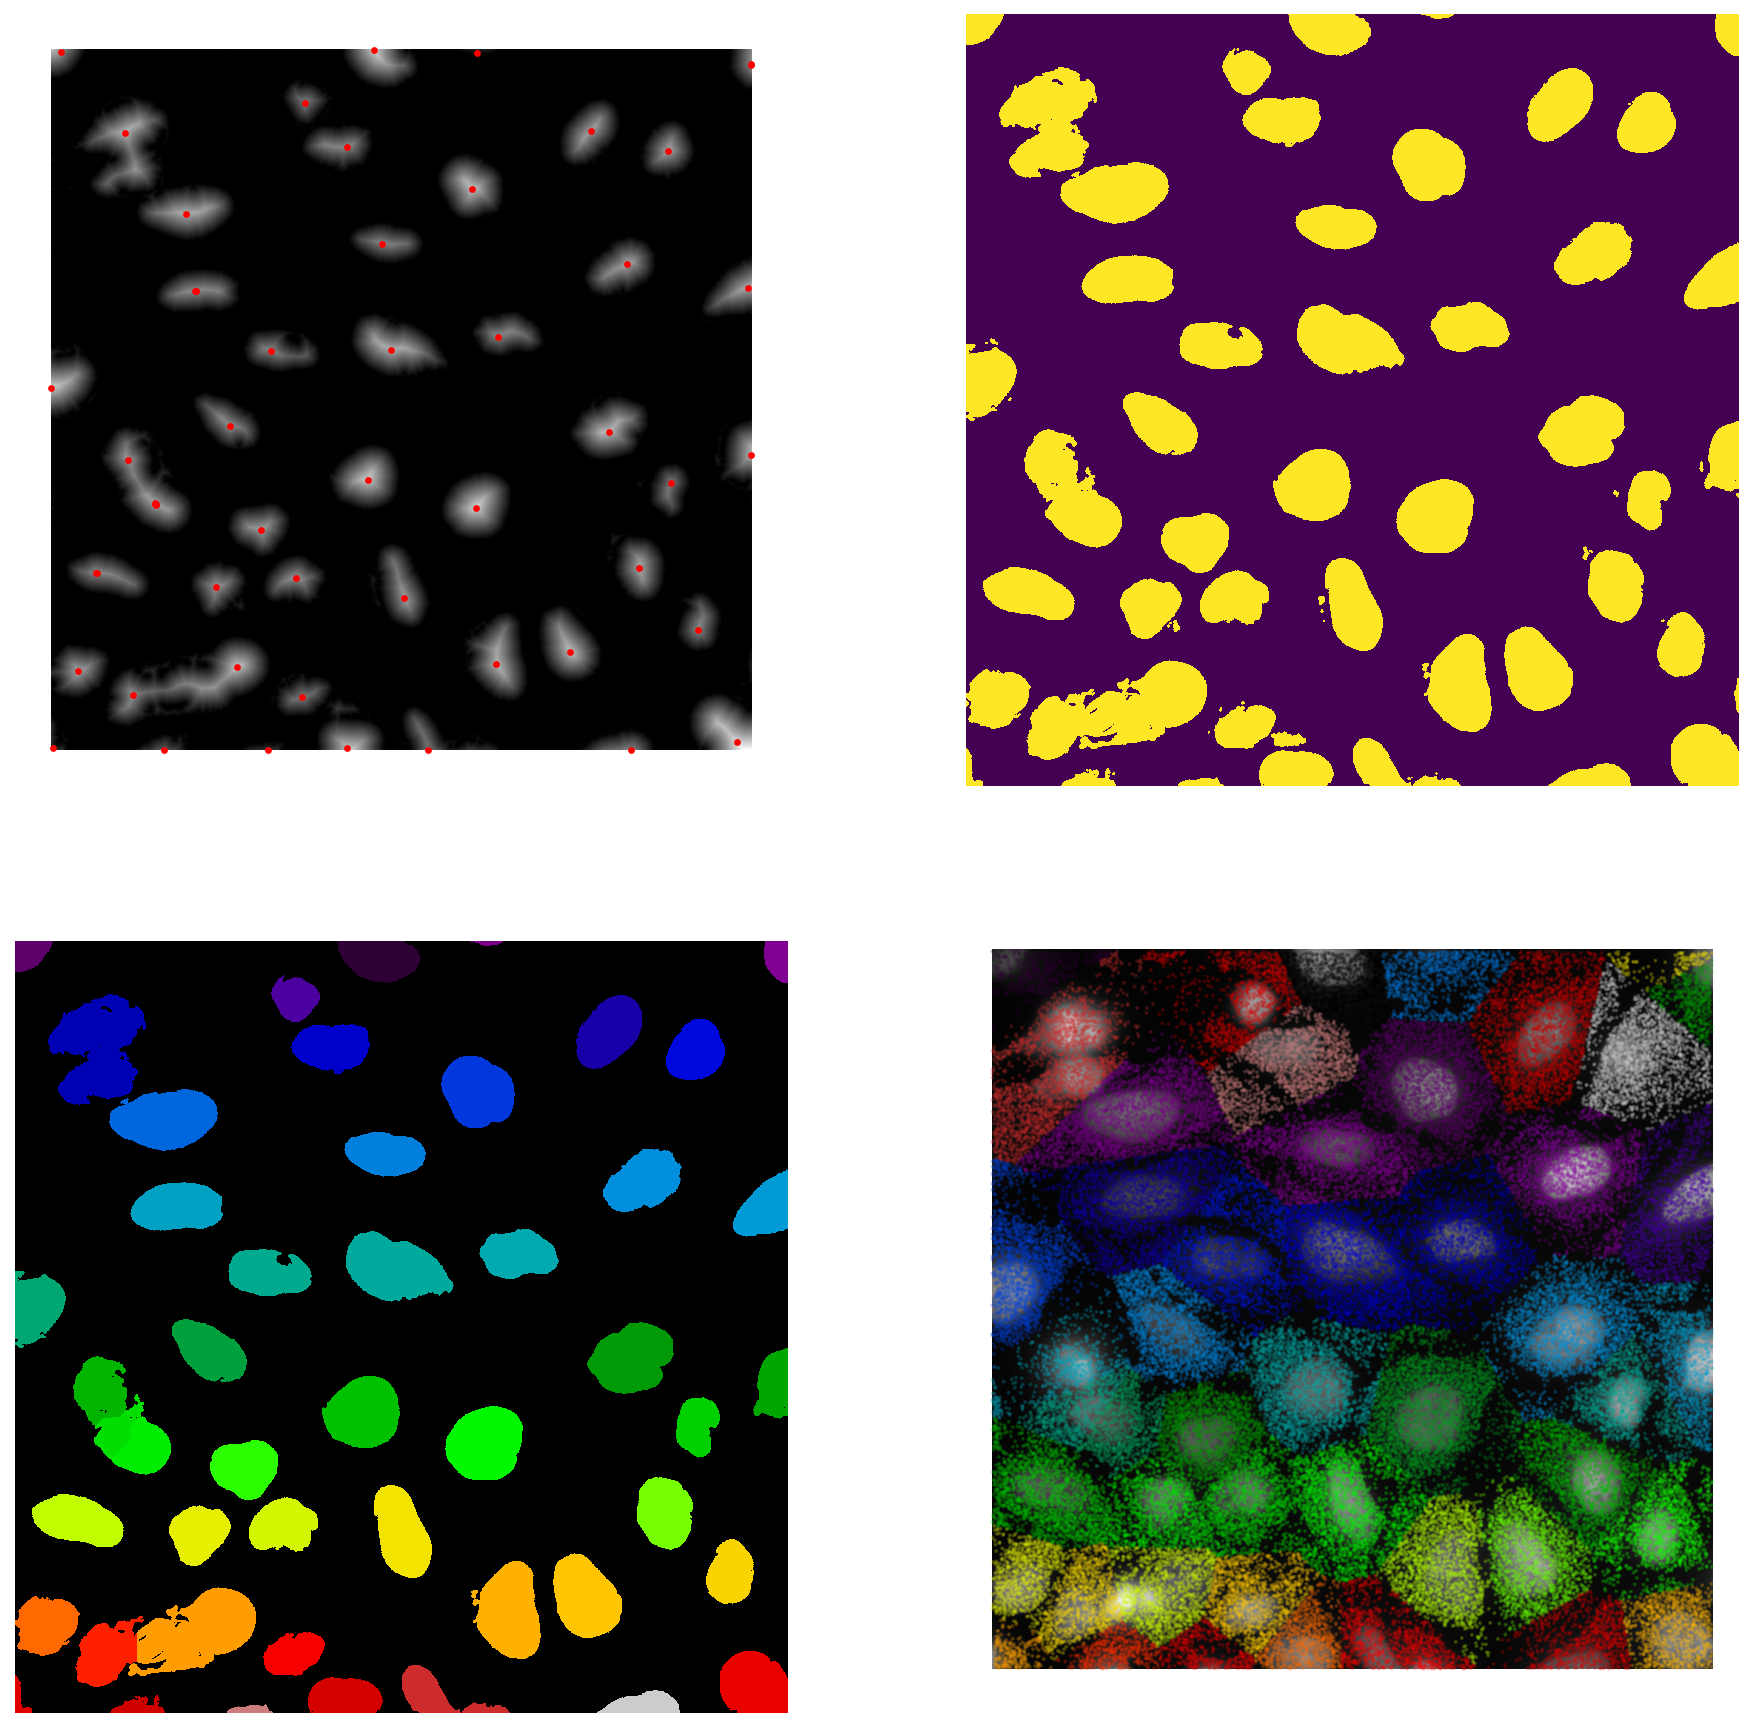

In [248]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, dpi=150, figsize=(15, 15))

y, x = np.where(markers)
ax1.imshow(dist, cmap=plt.cm.gray)
ax1.scatter(x, y, c='r', s=5)

ax2.imshow(mask)

ax3.imshow(objects, cmap=plt.cm.nipy_spectral)

ax4.imshow(np.squeeze(nuclei.xarray), cmap=plt.cm.gray)
colors_to_cells = {cell: i for i, cell in enumerate(np.unique(cxg.cell_id))}
colors = np.array([colors_to_cells[i] for i in assigned_spots.cell_id.values])
ax4.scatter(assigned_spots.x, assigned_spots.y, c=colors, alpha=0.2, cmap=plt.cm.nipy_spectral, s=1)

for ax in (ax1, ax2, ax3, ax4):
    ax.axes.set_axis_off()

Hah, nearest nucleus doesn't work so great on this data! Ah well... :-)